# Numerical Bifurcation Analysis of Large Scale Systems
## Homework 1

Consider the differential equation
$$u''(x) = \exp(x), \quad x \in (0,1)$$
with $u(0)=1$ and $\frac{\mathrm{d}u}{\mathrm{d}x}(1) = e$

1) The exact solution is given by $u(x) = c_0 + c_1x + \exp(x)$, where $c_0,c_1$ are constants. From the boundary values we get that $c_0=c_1=0$, hence $u(x) = \exp(x)$.

2) We will consider a grid of size $N$, so we have that $h=1/N$. For the interior nodes, we have the standard 3 point stencil
$$\dfrac{u_{i-1} - 2u_i + u_{i+1}}{h^2} = \exp(x_i)$$

For the left boundary, we just set $u_0 = 1$, for the right boundary, we add a ghost node $u_{N+1}$ and add the equation
$$\dfrac{u_{N+1} - u_{N-1}}{2h} = e$$

3) This results in the $N \times N$ finite difference matrix
$$\mathcal{D}=\dfrac{1}{h^2}
\begin{pmatrix}
-2 & 1 &  && \\
1 & -2 & 1 & &\\
&\ddots&\ddots&\ddots&\\
&&1 & -2 &1 \\
&& & 2 & -2 \\
\end{pmatrix}
$$

For the right hand side we have
$$f=
\begin{pmatrix}
\exp(x_1) - 1/h^2 \\
\exp(x_2) \\
\vdots \\
\exp(x_{N-1}) \\
\exp(x_N) - 2e/h
\end{pmatrix}
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

In [2]:
def construct_grid_pts(size):
    return np.linspace(0, 1, size + 1)

def construct_fde_spMat(size):
    # Construct diagonals
    lower_diag = np.ones(size)
    diag = -2 * np.ones(size)
    upper_diag = np.ones(size)
    
    # Adjust for Neumann boundary at 1
    lower_diag[-2] = 2
    diag_values = [lower_diag, diag, upper_diag]
    diags = [-1, 0, 1]
    
    # Construct tridiagonal finite difference matrix
    return size**2 * scipy.sparse.spdiags(diag_values, diags, m=size, 
                                          n=size, format="csr")

def construct_rhs_vec(size):
    x_values = construct_grid_pts(size)
    h = x_values[1] - x_values[0]
    rhs = np.zeros(size + 1)
    rhs = np.exp(x_values[1:len(rhs)])

    # Adjust for boundary conditions
    rhs[0] -= (h**-2) * 1
    rhs[-1] -= 2 * (h**-1) * np.exp(1)
    return rhs

def construct_bvp(size):
    return construct_fde_spMat(size), construct_rhs_vec(size)
    
def calculate_true_sol(size):
    return np.exp(np.linspace(0, 1, size + 1))
    
def calculate_bvp_sol(fde_spMat, rhs):
    adjusted_size = len(rhs) + 1
    sol = np.ones(adjusted_size)
    # u(0)=1, the rest we calculate by solving the linear system
    sol[1:len(sol)] = scipy.sparse.linalg.spsolve(fde_spMat, rhs)
    return sol, np.linspace(0, 1, adjusted_size)

### We will use these functions to calculate the solution to the bvp

Text(0, 0.5, '$u(x)')

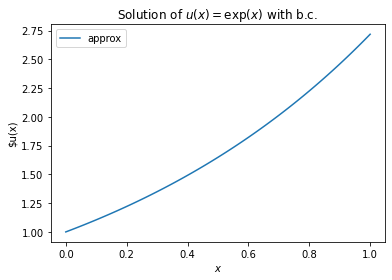

In [3]:
grid_size = 100
fde_spMat, rhs = construct_bvp(grid_size)

sol, grid_pts = calculate_bvp_sol(fde_spMat, rhs)

plt.plot(grid_pts, sol, label='approx')
plt.legend()
plt.title('Solution of $u''(x) = \exp(x)$ with b.c.')
plt.xlabel('$x$')
plt.ylabel('$u(x)')

### We will look at where the error is the largest

Text(0, 0.5, '$|u(x) - \\hat{u}(x)|$')

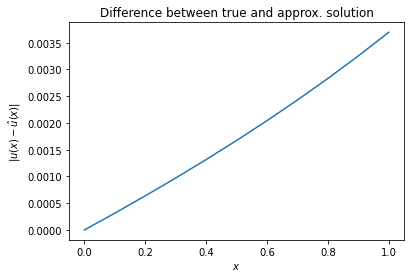

In [4]:
grid_size = 10
fde_spMat, rhs = construct_bvp(grid_size)

sol, grid_pts = calculate_bvp_sol(fde_spMat, rhs)
true = calculate_true_sol(grid_size)

plt.plot(grid_pts, np.abs(true - sol))
plt.title('Difference between true and approx. solution')
plt.xlabel('$x$')
plt.ylabel('$|u(x) - \hat{u}(x)|$')

### Lastly, we will look at the convergence with respect to $h$

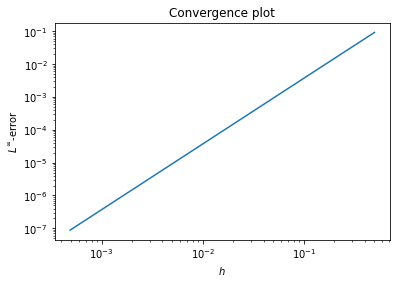

In [5]:
def convergence_analysis():
    num_experiments  = 12
    offset = 1
    error = np.zeros(num_experiments - offset)
    experiment = [2 ** -idx for idx in range(offset, num_experiments)]
    for idx in range(offset, num_experiments):
        size = 2 ** idx
        fde_spMat, rhs = construct_bvp(size)
        
        sol, _ = calculate_bvp_sol(fde_spMat, rhs)
        true = calculate_true_sol(size)
        
        error[idx - offset] = np.linalg.norm(true - sol, np.inf)
        
    plt.plot(experiment, error)    
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Convergence plot')
    plt.xlabel('$h$')
    plt.ylabel('$L^\infty$-error')
convergence_analysis()

## Conclusion
* The error is the biggest at $x=1$, so at the Neumann boundary
* We do indeed see $\mathcal{O}(h^2)$ convergence over the whole domain